<a href="https://colab.research.google.com/github/loiswoo/Time-Series/blob/main/TS_study_w4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARCH/GARCH를 이용하여 비트코인 종가 예측하기

데이터셋: https://www.kaggle.com/datasets/soham1024/bitcoin-time-series-data-till-02082020

참고한 자료 

https://machinelearningmastery.com/develop-arch-and-garch-models-for-time-series-forecasting-in-python/ - 베이스라인

https://www.fnspace.com/Community/CommunityView?rno=140 - ARCH 예시

https://arch.readthedocs.io/en/latest/univariate/introduction.html  - ARCH 모델 


[논문] GARCH 모형을 활용한 비트코인에 대한 체계적 위험분석

궁금한점


- X변수를 1) 주가 그대로 2) 수익률 계산 3) pct_change(변화율)
- arima + garch -https://medium.com/analytics-vidhya/arima-garch-forecasting-with-python-7a3f797de3ff 

In [1]:
!pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import statsmodels.api as sm
from statsmodels.tsa.api import adfuller
from statsmodels.graphics.tsaplots import plot_acf

In [3]:
from matplotlib import pyplot

In [4]:
df = pd.read_csv("/content/Bitcoin Historical Data.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3669 entries, 0 to 3668
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      3669 non-null   object
 1   Price     3669 non-null   object
 2   Open      3669 non-null   object
 3   High      3669 non-null   object
 4   Low       3669 non-null   object
 5   Vol.      3669 non-null   object
 6   Change %  3669 non-null   object
dtypes: object(7)
memory usage: 200.8+ KB


In [6]:
df.shape

(3669, 7)

In [7]:
df.head() #2010-7-18 ~2020-08-02

,Date,Price,Open,High,Low,Vol.,Change %
0,"Aug 02, 2020","11,105.8","11,802.6","12,061.1","10,730.7",698.62K,-5.91%
1,"Aug 01, 2020","11,803.1","11,333.2","11,847.7","11,226.1",611.47K,4.14%
2,"Jul 31, 2020","11,333.4","11,096.5","11,434.8","10,964.6",530.95K,2.14%
3,"Jul 30, 2020","11,096.2","11,105.8","11,164.4","10,861.6",501.14K,-0.09%
4,"Jul 29, 2020","11,105.9","10,908.4","11,336.5","10,771.8",576.83K,1.81%


In [8]:
df.tail()

,Date,Price,Open,High,Low,Vol.,Change %
3664,"Jul 22, 2010",0.1,0.1,0.1,0.1,2.16K,0.00%
3665,"Jul 21, 2010",0.1,0.1,0.1,0.1,0.58K,0.00%
3666,"Jul 20, 2010",0.1,0.1,0.1,0.1,0.26K,0.00%
3667,"Jul 19, 2010",0.1,0.1,0.1,0.1,0.57K,0.00%
3668,"Jul 18, 2010",0.1,0.0,0.1,0.1,0.08K,0.00%


분석의 정확도를 위하여

1) 최근 3년 데이터만 사용함

2) 비트코인의 가격은 범위 내의 가장 최신 데이터인 종가를 이용함.

In [9]:
#'Price'의 object를 float로 바꿔주기 위하여 ',' 제거
df.replace({'Price': ','}, '',  regex=True, inplace = True) #regex:부분 일치일때 사용

In [10]:
df['Price'] = df['Price'].astype(float) 

In [11]:
df["Date"] = pd.to_datetime(df.Date)

In [12]:
df = df[df['Date'].between('Aug 02, 2017', 'Aug 02, 2020')] #2017-08-02부터 2020-08-02

In [13]:
df.shape #

(1097, 7)

In [14]:
df.index = df['Date']

In [15]:
df = df[['Price']]

In [16]:
df.head()

,Price
Date,
2020-08-02,11105.8
2020-08-01,11803.1
2020-07-31,11333.4
2020-07-30,11096.2
2020-07-29,11105.9


## Check for Stationary

<Axes: xlabel='Date'>

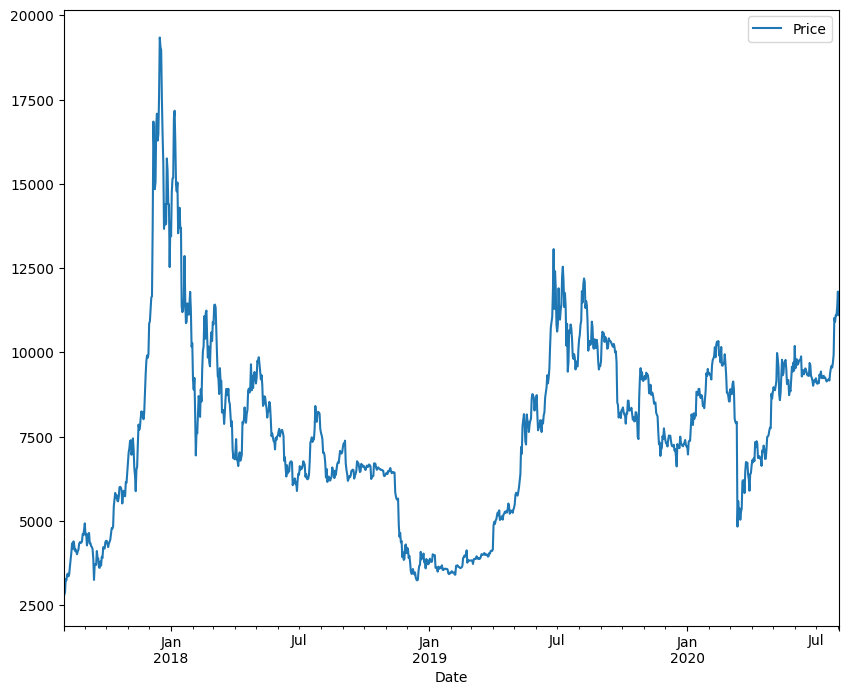

In [17]:
df.plot(figsize= (10,8))

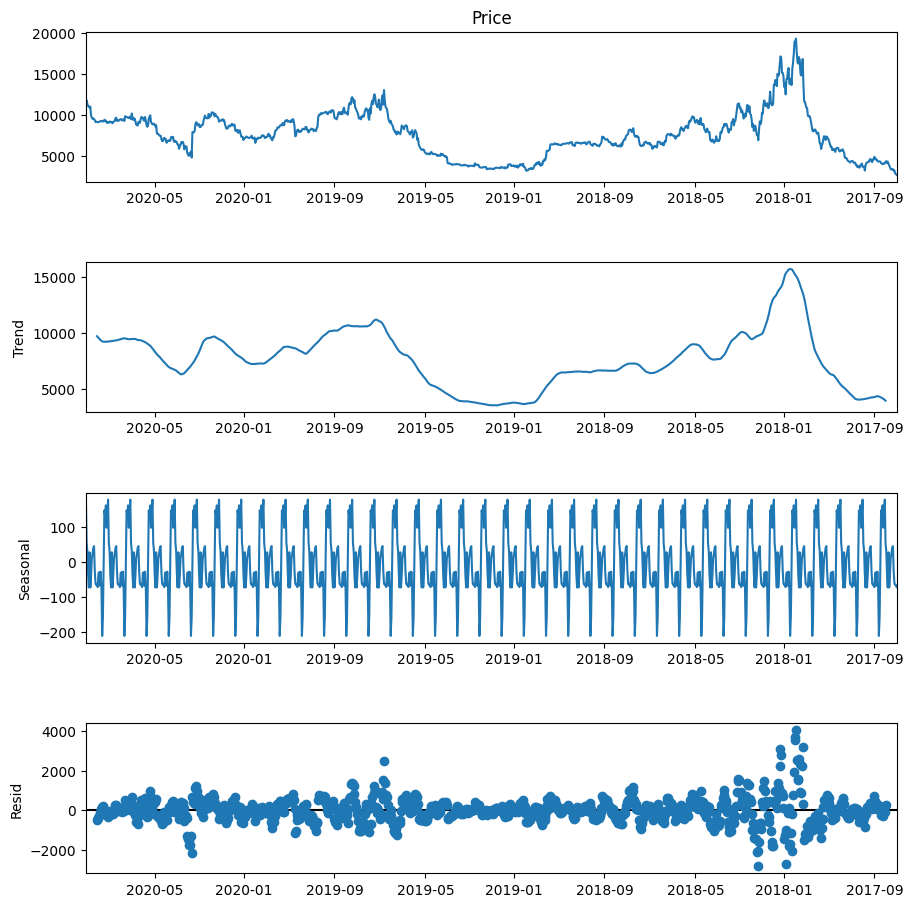

In [18]:
decomposition = sm.tsa.seasonal_decompose(df['Price'], model = 'additive', period = 30) #period를 1개월
fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()  

In [19]:
aftest = adfuller(df['Price'], autolag= "AIC")
print("ADF test statistic: {}".format(aftest[0]))
print("p-value: {}".format(aftest[1]))

ADF test statistic: -2.5324155216175748
p-value: 0.10778514298577879


adfuller test를 검정해보았을때, p-value의 값이 커서  non-stationary하다는 것을 알 수 있다.

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


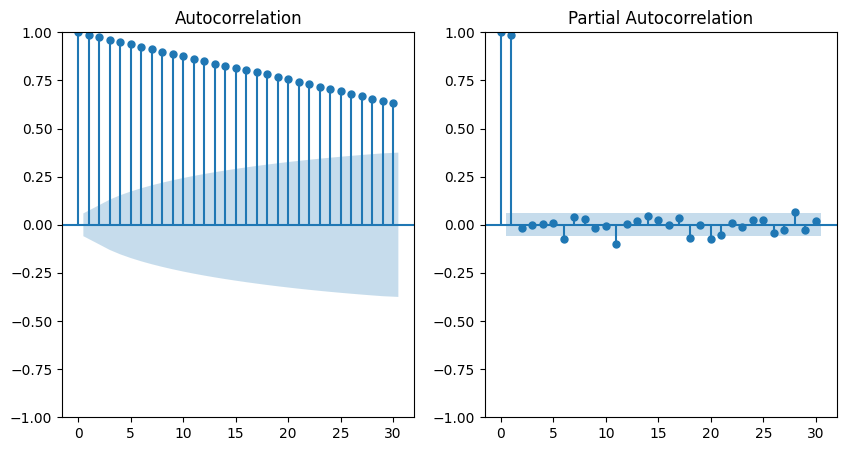

In [20]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
sm.graphics.tsa.plot_acf(df.Price.values.squeeze(), lags = 30, ax=ax[0] );
sm.graphics.tsa.plot_pacf(df.Price.values.squeeze(), lags = 30, ax = ax[1]);

autocorrelation function을 확인했을때, 값이 서서히 줄어드고 있는 것으로 보아서 non stationary하다는 것을 알 수 있다. 

In [21]:
#log 처리
df_log = np.log(df)

<Axes: xlabel='Date'>

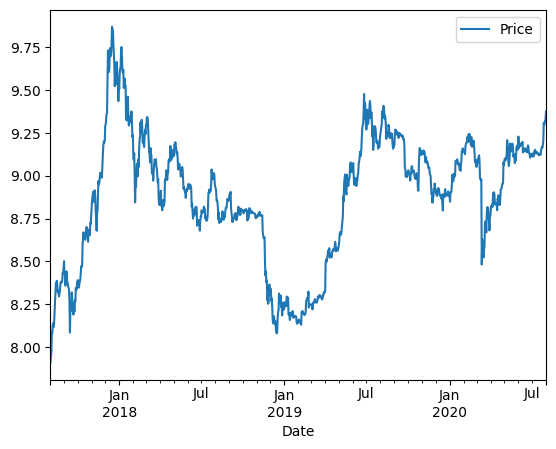

In [22]:
df_log.plot()

## ARCH model


In [23]:
#test: 마지막 30일
df_train = df_log.iloc[:-30,:]
df_test = df_log.iloc[-30:,:]

In [24]:
df_train.describe()

,Price
count,1067.000000
mean,8.896235
std,0.361841
min,8.079835
25%,8.740873
50%,8.947091
75%,9.142292
max,9.870215


In [25]:
#최적의 p 추정 
import itertools
p = range(0,31) 
aic = []
for i in p:
  try:
    model = arch_model(df_train['Price'], vol = 'ARCH',  p = (i))
    model_fit = model.fit()
    print(f'ARCH: {i} >> AIC: {round(model_fit.aic,2)}')
    aic.append(round(model_fit.aic,2))
  except:
    pass


Iteration:      1,   Func. Count:      5,   Neg. LLF: 17648558879.549683
Iteration:      2,   Func. Count:     14,   Neg. LLF: 637750044.3661172
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3312.260349818694
Iteration:      4,   Func. Count:     24,   Neg. LLF: 25092.553066683242
Iteration:      5,   Func. Count:     29,   Neg. LLF: 46075.40800692859
Iteration:      6,   Func. Count:     37,   Neg. LLF: -69.9182771722457
Iteration:      7,   Func. Count:     42,   Neg. LLF: 43456.27219418957
Iteration:      8,   Func. Count:     47,   Neg. LLF: 7384.755334230087
Iteration:      9,   Func. Count:     55,   Neg. LLF: -49.30789079263809
Iteration:     10,   Func. Count:     60,   Neg. LLF: 2330.490286386196
Iteration:     11,   Func. Count:     67,   Neg. LLF: 4800.806530343758
Iteration:     12,   Func. Count:     72,   Neg. LLF: 4169.043553402463
Iteration:     13,   Func. Count:     77,   Neg. LLF: 26394.276044954793
Iteration:     14,   Func. Count:     82,   Neg. LLF: 14173.

AIC를 기준으로 했을 때, p =2 일때 AIC: -345.08로 가장 낮기 때문에 p=2로 설정

In [26]:
#define model
model = arch_model(df_train['Price'], vol = 'ARCH', p = 2)

In [27]:
model_fit = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3685010911.8972883
Iteration:      2,   Func. Count:     16,   Neg. LLF: 643512343.8901072
Iteration:      3,   Func. Count:     22,   Neg. LLF: 6362.535498839281
Iteration:      4,   Func. Count:     28,   Neg. LLF: -32.13377710516329
Iteration:      5,   Func. Count:     34,   Neg. LLF: -158.35422208102062
Iteration:      6,   Func. Count:     39,   Neg. LLF: 48156477.56152017
Iteration:      7,   Func. Count:     50,   Neg. LLF: 286675110.1818245
Iteration:      8,   Func. Count:     59,   Neg. LLF: 813633.7806773863
Iteration:      9,   Func. Count:     65,   Neg. LLF: -20.027256441704765
Iteration:     10,   Func. Count:     71,   Neg. LLF: 6441.166806891612
Iteration:     11,   Func. Count:     77,   Neg. LLF: 25603.81323478448
Iteration:     12,   Func. Count:     83,   Neg. LLF: 1431.4829494728447
Iteration:     13,   Func. Count:     89,   Neg. LLF: 82379.76473228037
Iteration:     14,   Func. Count:     95,   Neg. LLF: 689

In [28]:
print(model_fit.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                176.542
Distribution:                  Normal   AIC:                          -345.083
Method:            Maximum Likelihood   BIC:                          -325.193
                                        No. Observations:                 1067
Date:                Thu, Mar 30 2023   Df Residuals:                     1066
Time:                        08:48:12   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             9.0146  1.441e-02    625.778      0.000 [  8.986,  9.04

In [29]:
#forecast
predict = model_fit.forecast(horizon = 30) #30일 예측

/usr/local/lib/python3.9/dist-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


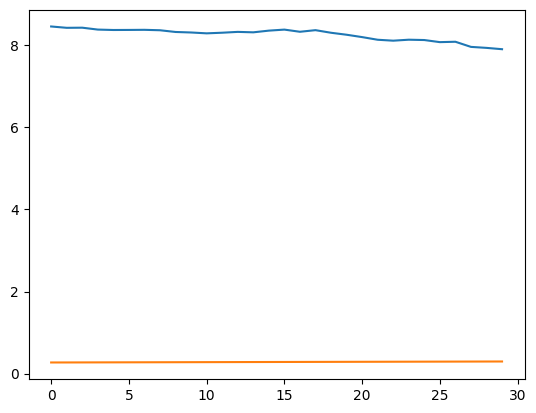

In [30]:
pyplot.plot(df_test.Price.values)
pyplot.plot(predict.variance.values[-1,:])
pyplot.show()

## GARCH Model

In [31]:
#최적의 p,q 추정
import itertools
p = range(0,10) 
q = range(0,10)
pq = list(itertools.product(p,q))
aic = []
for i,j in pq:
  try:
    model = arch_model(df_train['Price'], vol = 'GARCH',  p = (i), q = (j))
    model_fit = model.fit()
    print(f'GARCH: {i}, {j} >> AIC: {round(model_fit.aic,2)}')
    aic.append(round(model_fit.aic,2))
  except:
    pass


Iteration:      1,   Func. Count:      5,   Neg. LLF: 2529412.664663828
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1695.9171950099085
Iteration:      3,   Func. Count:     20,   Neg. LLF: 26195.309301305377
Iteration:      4,   Func. Count:     25,   Neg. LLF: -92.2301859609093
Iteration:      5,   Func. Count:     29,   Neg. LLF: -79.12683508313508
Iteration:      6,   Func. Count:     34,   Neg. LLF: 1424.4724450884787
Iteration:      7,   Func. Count:     39,   Neg. LLF: 39819.00940016755
Iteration:      8,   Func. Count:     44,   Neg. LLF: 10005.054221098639
Iteration:      9,   Func. Count:     49,   Neg. LLF: 1467.504326171684
Iteration:     10,   Func. Count:     55,   Neg. LLF: 793.7489457656625
Iteration:     11,   Func. Count:     60,   Neg. LLF: 46045.04666249887
Iteration:     12,   Func. Count:     65,   Neg. LLF: 3012.444617580839
Iteration:     13,   Func. Count:     70,   Neg. LLF: 13511.552223985196
Iteration:     14,   Func. Count:     75,   Neg. LLF: 3311

 AIC를 기준으로 한 결과, (p,q) = (2, 0) 일 때  AIC: -345.08가 가장 낮았기 때문에 (p,q) = (2, 0)로 선정.

In [32]:
model = arch_model(df_train, vol = 'GARCH', p= 2, q = 0) #GARCH(2,0) = ARCH(2)

In [33]:
model_fit2 = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2529105.682387821
Iteration:      2,   Func. Count:     17,   Neg. LLF: 32548.64210672402
Iteration:      3,   Func. Count:     23,   Neg. LLF: 8721.187719995787
Iteration:      4,   Func. Count:     29,   Neg. LLF: 27165.187680164185
Iteration:      5,   Func. Count:     35,   Neg. LLF: 10.993001785270678
Iteration:      6,   Func. Count:     40,   Neg. LLF: 41.057303724714046
Iteration:      7,   Func. Count:     48,   Neg. LLF: -150.41391134581167
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2061.404384649307
Iteration:      9,   Func. Count:     60,   Neg. LLF: 205.18521173160894
Iteration:     10,   Func. Count:     66,   Neg. LLF: -160.61654047883036
Iteration:     11,   Func. Count:     72,   Neg. LLF: -170.06902666547865
Iteration:     12,   Func. Count:     77,   Neg. LLF: -171.72985151317354
Iteration:     13,   Func. Count:     82,   Neg. LLF: -174.06414983335566
Iteration:     14,   Func. Count:     87,   Neg. L

In [34]:
print(model_fit2.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                176.542
Distribution:                  Normal   AIC:                          -345.083
Method:            Maximum Likelihood   BIC:                          -325.193
                                        No. Observations:                 1067
Date:                Thu, Mar 30 2023   Df Residuals:                     1066
Time:                        08:48:38   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             9.0146  1.440e-02    625.832      0.000 [  8.986,  9.04

In [35]:
predict2 = model_fit2.forecast(horizon = 30)

/usr/local/lib/python3.9/dist-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


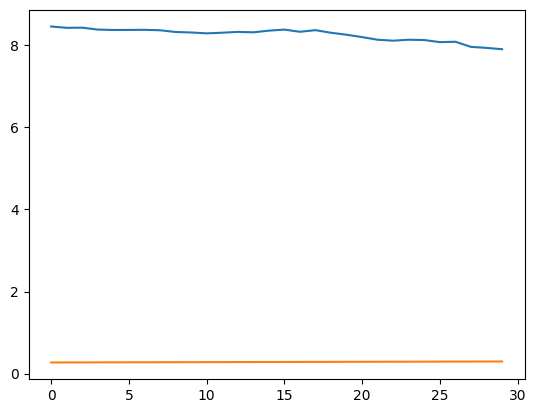

In [36]:
pyplot.plot(df_test.Price.values)
pyplot.plot(predict2.variance.values[-1,:])
pyplot.show()



---

